# Week 12: U-Net
## Convolutional Networks for Image Segmentation

Olaf Ronneberger, Philipp Fischer, and Thomas Brox
2015

U-Net is a segmentation network whose architecture resembles the letter "u". The network "contracts to capture context and a symmetric expanding path that enables precise localization" (Ronnenberger et al. 2015).

![unet.PNG](unet.PNG)

The example provided here will use a dataset of images we chose to use is labeled to classify cars. There are two labels in these images ('car' and 'not car'). 


## Weighted Mask

The use of the standard categorical cross-entropy loss function in U-net can be problematic for biomedical image segmentation:  
* When using this loss function, the model is rewarded for classifying narrow cell boundaries as being in-cell pixels because they are close to many other in-cell pixels  
* While this might not reduce the overall accuracy much, it reduces the usefulness of the segmentation result  
* To mitigate this problem, the implementation from the paper includes a weight map that is used to add a weight value to the loss function.  

This weight map is calculated as follows:

$$\Large
w(x) = w_c(x) + w_0\ \cdot\ exp\ (-\ \frac{(d_1(x) + d_2(x))^2}{2 \sigma^2})
$$

$$\small  
x\ is\ the\ current\ pixel \\  
w_c\ is\ the\ class\ weighting\ that\ upweights\ classes\ differently \\  
d_1\ is\ the\ distance\ to\ the\ nearest\ cell\ boundary \\  
d_2\ is\ the\ distance\ to\ the\ second\ nearest\ cell\ boundary \\  
w_0\ and\ \sigma\ are\ constants\ that\ scale\ the\ weighting $$  
  
### Example:  
Let's implement this in code. First we need to develop a function that can generate random cells to simulate a microscopy image:


In [1]:
# from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import os

def generate_random_circles(n = 50, d = 100, cell_size = 20):

  """
  Generate a numpy array that is a simulated mask for an image of 
  cells where the in-cell pixels are 1 and background pixels are 0. 
  Used as prelimiary generator for unet_weight_map function.

  Parameters
  ----------
  n:  int
      Number of cells to be created
  d:  int
      Dictionary of weight classes.
  Returns
  -------
  Numpy array
      Simulated mask for a cell-image. A 2D array of shape (d,d).
  """
  # Generate coordinates for random circles
  circles = np.random.randint(0, d, (n, 3))
  # Ensure radius (3rd col) is between d/3 and d
  circles[:,2] = np.interp(circles[:,2], (circles[:,2].max(), circles[:,2].max()), (d/3,d))

  # Generate background for simluated cell image 
  x = np.zeros((d, d), dtype=int)
  
  # Iterate over circles and insert into simulated image
  for x0, y0, r in circles:
    copy_x = deepcopy(x)
    # Generate new 2D array with circle of pixels with value 1 for current circle
    new_x = np.fromfunction(lambda x, y: ((x - x0)**2 + (y - y0)**2) <= (r/d*cell_size)**2, x.shape)
    
    # Add new circle to cell map
    for i in range(1,len(new_x)-1):
      for j in range(1,len(new_x[0])-1):
        # Only add to cell map if neighbours are 0
        if new_x[i][j] == True and x[i-1][j]==0 and x[i-1][j-1]==0 and x[i][j-1]==0 and x[i][j+1]==0 and x[i+1][j+1]==0 and x[i+1][j]==0 and x[i+1][j-1]==0 and x[i-1][j+1]==0:
          copy_x[i][j] += new_x[i][j]
    x += copy_x
  
  # Clip values above 1 to a max of 1
  x = np.clip(x, 0, 1)

  # Return simulated cell map
  return x

Second we need to implement the weighting function that weights each pixel in the image based on it's distance to the nearest cell boundaries:

In [2]:

def unet_weight_map(y, wc=None, w0 = 10, sigma = 5):

  """
  Generate weight maps as specified in the U-Net paper
  for boolean mask.
  
  "U-Net: Convolutional Networks for Biomedical Image Segmentation"
  https://arxiv.org/pdf/1505.04597.pdf
  
  Parameters
  ----------
  mask: Numpy array
      2D array of shape (image_height, image_width) representing binary mask
      of objects.
  wc: dict
      Dictionary of weight classes.
  w0: int
      Border weight parameter.
  sigma: int
      Border width parameter.
  Returns
  -------
  Numpy array
      Training weights. A 2D array of shape (image_height, image_width).
  """
  
  # Grab labels from input
  labels = label(y)
  no_labels = labels == 0
  label_ids = sorted(np.unique(labels))[1:]

  # Check for circles in y
  if len(label_ids) > 1:
    # Calculate distances
    distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))
    for i, label_id in enumerate(label_ids):
      distances[:,:,i] = distance_transform_edt(labels != label_id)

    # Sort for nearest cell boundary distances
    distances = np.sort(distances, axis=2)
    d1 = distances[:,:,0]
    d2 = distances[:,:,1]
    
    # Calculate second term in weighting equation
    w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels

    # Sum with class weights to produce weighted mask
    if wc:
      class_weights = np.zeros_like(y)
      for k, v in wc.items():
        class_weights[y == k] = v
      w = w + class_weights
  
  # If no circles we passed in to the function, return zeros
  else:
    w = np.zeros_like(y)
  
  # Return weighted mask
  return w


Let's generate a simulated cell image mask and then weight the pixels of that mask. You need to choose weighting values for the two classes, cell and non-cell:

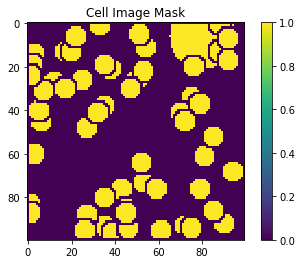

Class Weighting: {0: 2, 1: 0}


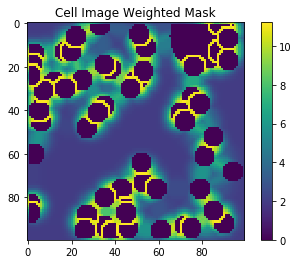

In [3]:
# Generate simulated cell mask 
num_cells        = 60
image_dimensions = 100
cell_size        = 15
y = generate_random_circles(num_cells, image_dimensions, cell_size)

# Display cell mask
plt.imshow(y)
plt.title('Cell Image Mask')
plt.colorbar()
plt.show()

# Weighting for pixels assigned to the two classes
class_weighting = {
  # TODO: Choose weighting values for the classes in the cell mask - they are currently set to 0.
  0: 2, # background
  1: 0  # cells
}

print('Class Weighting:', class_weighting)

# Generate weighted map
w = unet_weight_map(y, class_weighting, w0=10)

# Display weighted mask
plt.imshow(w)
plt.title('Cell Image Weighted Mask')
plt.colorbar()
plt.show()

**TO DO: Try adjusting the weighting of the class in the class_weighting dictionary (or other parameters) and see what impact that has on the final weighted mask.**

Intuitively, a higher background weight means that it is more likely for the background to be detected and a higher cell weight means that it is more likely for the cells to be detected.  Ideally neither the background nor the cells should be detected, simply the cell borders with respect to each other.  As well, the only factor which significantly effects the image is the relative difference between the cell class weight and the boundary call weight.  However, there is a significant amount of "glow" from these boundaries.  Seemingly this glow can only be reduced by increasing the background weight slightly, thus increasing the background recognition slightly and indirectly reducing the glow.

# Implementing U-Net

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as TF

We use the double convolution quite a lot in this architecture so let's implement it as a reusable code block.

In [5]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),  # 3x3 convolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


Now let's devise the network using Pytorch functionality.

In [6]:

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

For a sanity check, let's just make sure that we are getting a prediction that is the shape we would expect.

**QUESTION: Given the shape of the torch.randn() and the fact that we're using padding, what do you expect the output shape to be?**

The output and input will be the same shape.  This can be seen empirically with x below, since preds and x have the same shape.  Therefore, with the data example, the data shape will be 160x240.

In [7]:
x = torch.randn((3, 1, 50, 50))
model = UNET(in_channels=1, out_channels=1)
preds = model(x)
assert preds.shape == x.shape


### Dataset Loader
Now we'll prepare our data for training and testing using Pytorch's DataLoader which will pass in samples in “minibatches”.

In [8]:
from PIL import Image
from torch.utils.data import Dataset

class CarDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

### Useful Utility Functions
Some of the operations we perform can be functionalized to save on repetition. The two examples below are getting the data loaders and validating the model.

In [9]:
from torch.utils.data import DataLoader

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
):
    train_ds = CarDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = CarDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

def validation_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x
            y = y.unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
    print(f"Got {num_correct}/{num_pixels} pixels with acc {num_correct/num_pixels*100:.2f}")
    model.train()

### Training Function

In [10]:
def train_fn(loader, model, optimizer, loss_fn):

    for batch_idx, (data, targets) in enumerate(loader):

        # forward
        predictions = model(data)
        loss = loss_fn(predictions, targets.float().unsqueeze(1))

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Iter: {batch_idx+1}/{len(loader.dataset)}, Loss: {loss.item():.04f}")


### Hyperparameters
Choose hyperparameters for the model. Experiment with the learning rate and batch size.

In [11]:
# Hyperparameters

# TODO: experiment with different values
LEARNING_RATE = 1e-4
BATCH_SIZE = 1

IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
LOAD_MODEL = False

cwd = os.getcwd()

TRAIN_IMG_DIR = os.path.join(cwd, "data", "train_images")
TRAIN_MASK_DIR = os.path.join(cwd, "data", "train_masks")
VAL_IMG_DIR = os.path.join(cwd, "data", "val_images")
VAL_MASK_DIR = os.path.join(cwd, "data", "val_masks")

### Data Transformation
The images in this dataset are quite large, so we will need to reduce the size in order to make the training time a little more reasonable. While this might sacrifice some accuracy due to compression, we can run more data through the model during training this way.

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

val_transforms = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)


### Training the Model

**Question: Why do we use the BCEWithLogitsLoss function for training the model?**  
The documentation is [here](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

BCDWithLogitsLoss is much more numerically stable than just simply using BCELoss and a sigmoid layer.

**Question: Given the authors of the original U-Net paper chose SGD, is Adam the best optimizer for this implementation?**  
Consider trying [a couple of different ones](https://pytorch.org/docs/stable/optim.html#algorithms) and see what happens.

As can be seen below, Adam is prefferable to SGD, since SGD leads to a much worse distinction between the background and foreground.  SGD tends to capture the shadows rather than actually segmenting the car.  Adam also has a better validation accuracy.

#### SGD

In [19]:
model = UNET(in_channels=3, out_channels=1)

loss_fn = nn.BCEWithLogitsLoss()

import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)

train_fn(train_loader, model, optimizer, loss_fn)

Iter: 1/224, Loss: 0.6824
Iter: 2/224, Loss: 0.6861
Iter: 3/224, Loss: 0.7010
Iter: 4/224, Loss: 0.6787
Iter: 5/224, Loss: 0.6981
Iter: 6/224, Loss: 0.6991
Iter: 7/224, Loss: 0.6989
Iter: 8/224, Loss: 0.7001
Iter: 9/224, Loss: 0.7042
Iter: 10/224, Loss: 0.6989
Iter: 11/224, Loss: 0.6971
Iter: 12/224, Loss: 0.6933
Iter: 13/224, Loss: 0.6893
Iter: 14/224, Loss: 0.6908
Iter: 15/224, Loss: 0.6790
Iter: 16/224, Loss: 0.6874
Iter: 17/224, Loss: 0.6861
Iter: 18/224, Loss: 0.6805
Iter: 19/224, Loss: 0.6744
Iter: 20/224, Loss: 0.6844
Iter: 21/224, Loss: 0.6814
Iter: 22/224, Loss: 0.6851
Iter: 23/224, Loss: 0.7027
Iter: 24/224, Loss: 0.6697
Iter: 25/224, Loss: 0.6768
Iter: 26/224, Loss: 0.6987
Iter: 27/224, Loss: 0.6819
Iter: 28/224, Loss: 0.6816
Iter: 29/224, Loss: 0.6717
Iter: 30/224, Loss: 0.6688
Iter: 31/224, Loss: 0.6804
Iter: 32/224, Loss: 0.6691
Iter: 33/224, Loss: 0.6804
Iter: 34/224, Loss: 0.6766
Iter: 35/224, Loss: 0.6642
Iter: 36/224, Loss: 0.6617
Iter: 37/224, Loss: 0.6572
Iter: 38/2

In [20]:
validation_accuracy(val_loader, model)

Got 1889940/2457600 pixels with acc 76.90


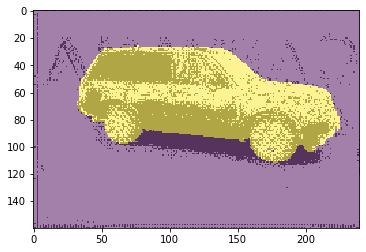

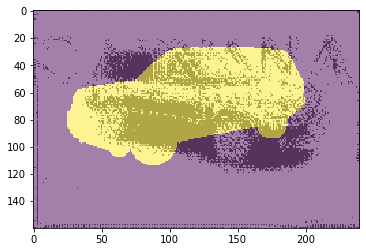

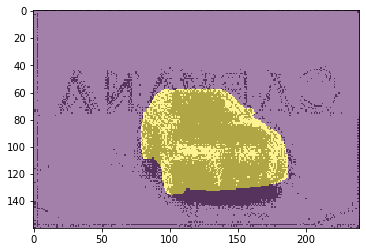

In [21]:
# TODO: how many predictions do you want to visualize?
num_predictions = 3

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(model(val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()
  

#### Adam

In [32]:
model = UNET(in_channels=3, out_channels=1)

loss_fn = nn.BCEWithLogitsLoss()

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)

train_fn(train_loader, model, optimizer, loss_fn)


Iter: 1/224, Loss: 0.6328
Iter: 2/224, Loss: 0.5339
Iter: 3/224, Loss: 0.5520
Iter: 4/224, Loss: 0.5288
Iter: 5/224, Loss: 0.5106
Iter: 6/224, Loss: 0.4256
Iter: 7/224, Loss: 0.4654
Iter: 8/224, Loss: 0.4476
Iter: 9/224, Loss: 0.3734
Iter: 10/224, Loss: 0.3383
Iter: 11/224, Loss: 0.4068
Iter: 12/224, Loss: 0.3502
Iter: 13/224, Loss: 0.3073
Iter: 14/224, Loss: 0.3539
Iter: 15/224, Loss: 0.3319
Iter: 16/224, Loss: 0.3128
Iter: 17/224, Loss: 0.2801
Iter: 18/224, Loss: 0.2574
Iter: 19/224, Loss: 0.2423
Iter: 20/224, Loss: 0.3854
Iter: 21/224, Loss: 0.3412
Iter: 22/224, Loss: 0.2582
Iter: 23/224, Loss: 0.3056
Iter: 24/224, Loss: 0.2302
Iter: 25/224, Loss: 0.2477
Iter: 26/224, Loss: 0.2452
Iter: 27/224, Loss: 0.2600
Iter: 28/224, Loss: 0.2294
Iter: 29/224, Loss: 0.2267
Iter: 30/224, Loss: 0.2427
Iter: 31/224, Loss: 0.2311
Iter: 32/224, Loss: 0.2346
Iter: 33/224, Loss: 0.2439
Iter: 34/224, Loss: 0.2489
Iter: 35/224, Loss: 0.2130
Iter: 36/224, Loss: 0.2243
Iter: 37/224, Loss: 0.2353
Iter: 38/2

### Validating the Model

In [33]:
validation_accuracy(val_loader, model)

Got 2218810/2457600 pixels with acc 90.28


Let's visualise a couple randomly selected validation predictions and see how well the model did.

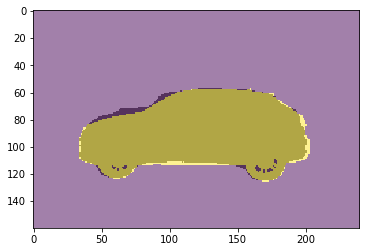

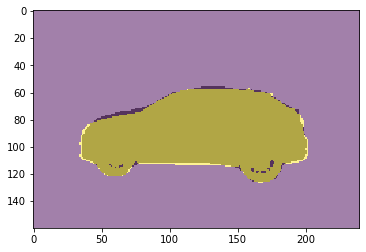

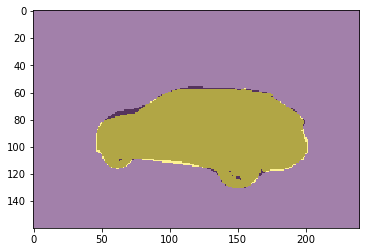

In [34]:
# TODO: how many predictions do you want to visualize?
num_predictions = 3

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(model(val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()
  

**Question: What you do notice about the predicted mask that is less than optimal?**  
There are spots, while small, where there are discontinuities between the predicted mask and the segmented portion of the car.

### Data Augmentation
Let's train the model on some new data (in a sense). We can augment the data that we feed to the model by performing horizontal flips on the images of the cars, or even changing the distribution of the normalized values. 

In [35]:
train_transform = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[2.0, 2.0, 2.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

val_transforms = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[2.0, 2.0, 2.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)


Now continue training the model:

In [36]:
train_fn(train_loader, model, optimizer, loss_fn)

Iter: 1/224, Loss: 0.1517
Iter: 2/224, Loss: 0.1494
Iter: 3/224, Loss: 0.1372
Iter: 4/224, Loss: 0.1775
Iter: 5/224, Loss: 0.1346
Iter: 6/224, Loss: 0.1498
Iter: 7/224, Loss: 0.1401
Iter: 8/224, Loss: 0.1551
Iter: 9/224, Loss: 0.1341
Iter: 10/224, Loss: 0.1294
Iter: 11/224, Loss: 0.1256
Iter: 12/224, Loss: 0.1260
Iter: 13/224, Loss: 0.1394
Iter: 14/224, Loss: 0.1260
Iter: 15/224, Loss: 0.1188
Iter: 16/224, Loss: 0.1319
Iter: 17/224, Loss: 0.1242
Iter: 18/224, Loss: 0.1273
Iter: 19/224, Loss: 0.1751
Iter: 20/224, Loss: 0.1483
Iter: 21/224, Loss: 0.1164
Iter: 22/224, Loss: 0.1724
Iter: 23/224, Loss: 0.1406
Iter: 24/224, Loss: 0.1303
Iter: 25/224, Loss: 0.1295
Iter: 26/224, Loss: 0.1586
Iter: 27/224, Loss: 0.1391
Iter: 28/224, Loss: 0.1266
Iter: 29/224, Loss: 0.1571
Iter: 30/224, Loss: 0.1270
Iter: 31/224, Loss: 0.1312
Iter: 32/224, Loss: 0.1232
Iter: 33/224, Loss: 0.1570
Iter: 34/224, Loss: 0.1420
Iter: 35/224, Loss: 0.1309
Iter: 36/224, Loss: 0.1191
Iter: 37/224, Loss: 0.1180
Iter: 38/2

Take a look at some of the model predictions.  
  
**Question: How has the model performance changed and why?**  

The model will be better able to predict horizonal flips of cars.  This can be seen below where several cars have masks which are horizontal flips of the predictions.

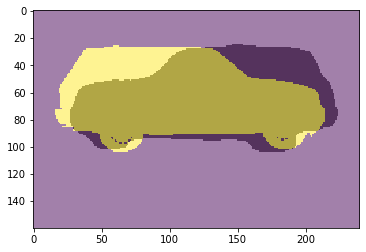

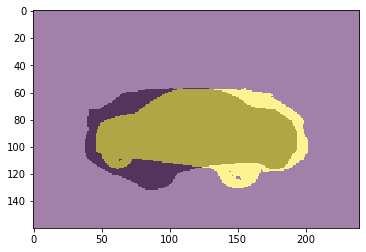

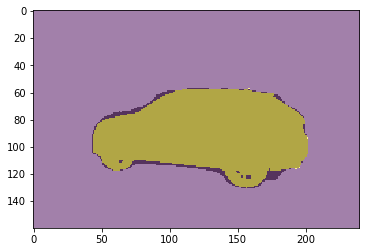

In [37]:
# TODO: how many predictions do you want to visualize?
num_predictions = 3

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(model(val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()


**As an optional final task, try training a new model on variations of augmented data and see how the performance changes with different augmentations.** 